# Load python packages needed

In [1]:
!pip install nltk

In [2]:
!pip install -U scikit-learn

  Using cached https://files.pythonhosted.org/packages/73/db/7d8204ddba84ab5d1e4fd1af8f82bbe39c589488bee71e45c662f4144010/scikit_learn-0.22.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/28/5c/cf6a2b65a321c4a209efcdf64c2689efae2cb62661f8f6f4bb28547cf1bf/joblib-0.14.1-py2.py3-none-any.whl
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [16]:
from collections import *

import csv
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.utils.multiclass import unique_labels

from sklearn.linear_model import SGDClassifier, LogisticRegression

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.utils import resample

from joblib import dump, load

%matplotlib inline

In [4]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
vocab = []

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Summarize Coded Data

In [5]:
def summarize_data(data):
    for col in data.columns:
        if col not in ['Hashed_ID', 'Text']:
            vc = data[col].value_counts(dropna=False)
            per = vc/data.shape[0]
            summary = pd.DataFrame({'Counts': vc, 'Percent': per})
            print(col, "\n", summary, "\n")

In [6]:
data = pd.read_excel('Final Codes for Erkin_KQ.xlsx')

print("n evaluations: %s\n" %(data.shape[0]))
summarize_data(data)

n evaluations: 2416

Final 
        Counts   Percent
e        1014  0.419702
m         787  0.325745
I         582  0.240894
other      24  0.009934
i           9  0.003725 

Relevant 
    Counts   Percent
t    2392  0.990066
f      24  0.009934 

Specific 
      Counts   Percent
t      1490  0.616722
f       902  0.373344
NaN      24  0.009934 

Corrective 
      Counts   Percent
t      1319  0.545944
f      1073  0.444123
NaN      24  0.009934 



## Finalize data
make all the strings lower case <br>
calculate final_high (primary outcome) <br>
    if final is in {"e", "m"} -> 1 (True)<br>
    else -> 0 (False) <br>
convert True -> 1 and False -> 0 <br>
replace NaNs with 0s <br>

In [7]:
data = data.apply(lambda x: x.astype(str).str.lower())
data['Final_High'] = data['Final'].isin(['e', 'm'])
data['Final_High'] = data['Final_High'].replace({True: 1, False: 0})

data['Relevant'] = data['Relevant'].replace({'t': 1, 'f': 0, 'nan': 0})
data['Specific'] = data['Specific'].replace({'t': 1, 'f': 0, 'nan': 0})
data['Corrective'] = data['Corrective'].replace({'t': 1, 'f': 0, 'nan': 0})

for col in ['Relevant', 'Specific', 'Corrective', 'Final_High']:
    data[col] = pd.to_numeric(data[col])

summarize_data(data)

Final 
        Counts   Percent
e        1014  0.419702
m         787  0.325745
i         591  0.244619
other      24  0.009934 

Relevant 
    Counts   Percent
1    2392  0.990066
0      24  0.009934 

Specific 
    Counts   Percent
1    1490  0.616722
0     926  0.383278 

Corrective 
    Counts   Percent
1    1319  0.545944
0    1097  0.454056 

Final_High 
    Counts   Percent
1    1801  0.745447
0     615  0.254553 



# Train Model

In [8]:
outcome_names = ['Relevant', 'Specific', 'Corrective', 'Final', 'Final_High']
text = list(data['Text'])
outcomes = { colName: list(data[colName]) for colName in outcome_names}

In [9]:
feature_name = "Text"
label_names = ["Relevant", "Specific", "Corrective", "Final", "Final_High"]
primary_label_name = "Final_High"

In [71]:
X = list(data[feature_name])
Y = data[outcome_names].to_numpy()

In [82]:
X_train, X_test, Y_train, Y_test = \
train_test_split(X, Y, test_size=0.25, random_state=42)

In [12]:
model = make_pipeline(
            CountVectorizer(), 
            TfidfTransformer(), 
            LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=0)
        )

In [83]:
pl_idx = label_names.index(primary_label_name)
primary_train_label = list(Y_train[:, pl_idx])

## Find the best hyperparameters - use random CV search

In [16]:
param_grid = {
    "countvectorizer__stop_words": [None, 'english'],
    "countvectorizer__ngram_range": [(1,1), (1,3), (1,5), (1, 10)],
    "tfidftransformer__norm": ["l1", "l2", None],
    "tfidftransformer__use_idf": [True, False],
    "tfidftransformer__sublinear_tf": [True, False],
    "logisticregression__penalty": ["l1", "l2", "elasticnet"],
    "logisticregression__C": [0.1, 1, 5, 10],
    "logisticregression__l1_ratio": [0.15, 0.5, 0.85],
}

In [20]:
search = RandomizedSearchCV(model, param_grid, n_iter=50, cv=4, n_jobs=-1, verbose=1)
search.fit(X_train, primary_train_label)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.1min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('countvectorizer',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                               

In [21]:
print("Best parameters set found on development set:")
print()
print("%0.3f" %search.best_score_)
print(search.best_params_)
print()
print("Scores on development set:")
print()
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Best parameters set found on development set:

0.827
{'tfidftransformer__use_idf': False, 'tfidftransformer__sublinear_tf': False, 'tfidftransformer__norm': 'l2', 'logisticregression__penalty': 'elasticnet', 'logisticregression__l1_ratio': 0.15, 'logisticregression__C': 5, 'countvectorizer__stop_words': None, 'countvectorizer__ngram_range': (1, 5)}

Scores on development set:

0.803 (+/-0.027) for {'tfidftransformer__use_idf': True, 'tfidftransformer__sublinear_tf': False, 'tfidftransformer__norm': None, 'logisticregression__penalty': 'elasticnet', 'logisticregression__l1_ratio': 0.85, 'logisticregression__C': 10, 'countvectorizer__stop_words': None, 'countvectorizer__ngram_range': (1, 1)}
0.741 (+/-0.002) for {'tfidftransformer__use_idf': True, 'tfidftransformer__sublinear_tf': False, 'tfidftransformer__norm': 'l2', 'logisticregression__penalty': 'elasticnet', 'logisticregression__l1_ratio': 0.5, 'logisticregression__C': 0.1, 'countvectorizer__stop_words': 'english', 'countvectorizer_

In [22]:
best = search.best_estimator_
best_params = search.best_params_

In [23]:
best.fit(X_train, primary_train_label)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 5), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, voc...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
                ('logisticregression',
                 LogisticRegression(C=5, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
               

In [24]:
primary_test_label_prediction = best.predict(X_test)

In [25]:
primary_test_label = list(Y_test[:, pl_idx])
np.mean(primary_test_label == primary_test_label_prediction)

0.8261589403973509

# Evaluate best model on the outcomes

In [13]:
def evaluate(model, X, y):
    
    y_hat = model.predict(X)
    print("Accuracy: %0.3f" %np.mean(y == y_hat))
    
    plot_confusion_matrix(y, y_hat)
    p_hat = model.predict_proba(X)[:,1]
    
    if len(set(y))<3:
        roc_curve(y, p_hat)
    
    print(classification_report(y, y_hat))
    
    bootstrap_res = []
    for _ in range(1000):
        _y, _y_hat, _p_hat = resample(y, y_hat, p_hat)
        acc = np.mean(_y == _y_hat)
        bootstrap_res.append((acc, _y, _y_hat, _p_hat))
    
    print("--------------------------------------------------------------------------------")
    print("bootstrapping on accuracy...")
    bootstrap_res = sorted(bootstrap_res, key=lambda x: x[0])
    
    acc, lb_y, lb_y_hat, lb_p_hat = bootstrap_res[24]
    acc, ub_y, ub_y_hat, ub_p_hat = bootstrap_res[-25]
    
    print("...lowerbound (5%)")
    plot_confusion_matrix(lb_y, lb_y_hat)
    print(classification_report(lb_y, lb_y_hat))
    
    print("...upperbound (95%)")
    plot_confusion_matrix(ub_y, ub_y_hat)
    print(classification_report(ub_y, ub_y_hat))
    
    if len(set(y))<3:
        bs_roc_curve(y, p_hat, lb_y, lb_p_hat, ub_y, ub_p_hat)
        
    plt.show()
    
    
    

In [20]:
def plot_confusion_matrix(y_true, y_pred, classes=None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          cmPrint=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if not classes:
        classes = set(y_true)
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if cmPrint:
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #return ax

    plt.show()

In [22]:
def roc_curve(y, p_hat):
    fpr, tpr, thresholds = metrics.roc_curve(y, p_hat)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='teal',
             lw=lw, label='ROC curve (AUROC: %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [23]:
def bs_roc_curve(y, p_hat, lb_y, lb_p_hat, ub_y, ub_p_hat):
    fpr, tpr, thresholds = metrics.roc_curve(y, p_hat)
    roc_auc = metrics.auc(fpr, tpr)
    
    lb_fpr, lb_tpr, lb_thresholds = metrics.roc_curve(lb_y, lb_p_hat)
    lb_roc_auc = metrics.auc(lb_fpr, lb_tpr)
    
    ub_fpr, ub_tpr, ub_thresholds = metrics.roc_curve(ub_y, ub_p_hat)
    ub_roc_auc = metrics.auc(ub_fpr, ub_tpr)    

    plt.figure()
    lw = 2
    plt.plot(ub_fpr, ub_tpr, color='grey',
             lw=lw-1, linestyle=(0, (1, 1)), label='UB ROC curve (AUROC: %0.2f)' % ub_roc_auc)     
    plt.plot(fpr, tpr, color='teal',
             lw=lw, label='ROC curve (AUROC: %0.2f)' % roc_auc)
    plt.plot(lb_fpr, lb_tpr, color='grey',
             lw=lw-1, linestyle=(0, (5, 1)), label='LB ROC curve (AUROC: %0.2f)' % lb_roc_auc)
    
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Relevant
--------------------------------------------------------------------------------
Relevant - train
--------------------------------------------------------------------------------
Accuracy: 0.993


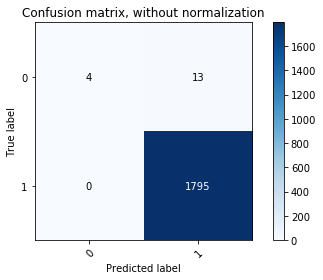

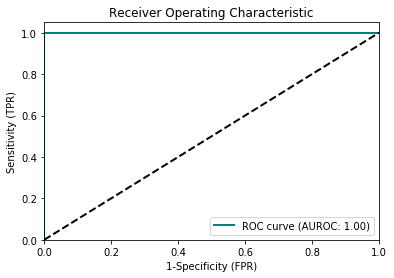

              precision    recall  f1-score   support

           0       1.00      0.24      0.38        17
           1       0.99      1.00      1.00      1795

    accuracy                           0.99      1812
   macro avg       1.00      0.62      0.69      1812
weighted avg       0.99      0.99      0.99      1812

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


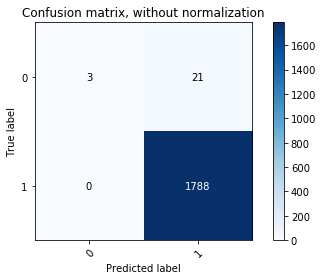

              precision    recall  f1-score   support

           0       1.00      0.12      0.22        24
           1       0.99      1.00      0.99      1788

    accuracy                           0.99      1812
   macro avg       0.99      0.56      0.61      1812
weighted avg       0.99      0.99      0.98      1812

...upperbound (95%)


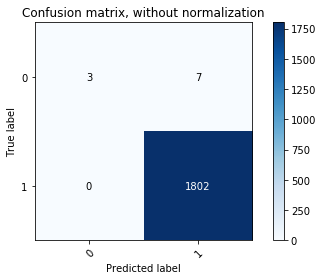

              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       1.00      1.00      1.00      1802

    accuracy                           1.00      1812
   macro avg       1.00      0.65      0.73      1812
weighted avg       1.00      1.00      1.00      1812



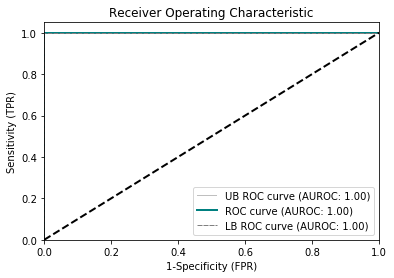

--------------------------------------------------------------------------------
Relevant - test
--------------------------------------------------------------------------------
Accuracy: 0.987


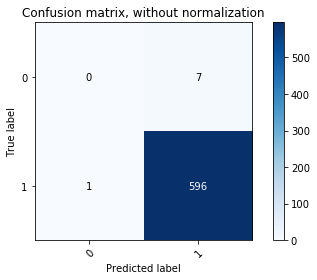

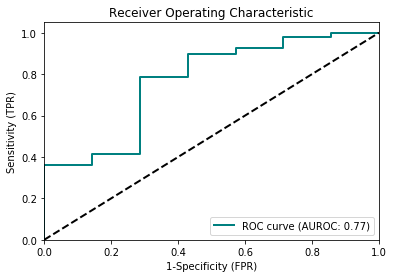

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.99      1.00      0.99       597

    accuracy                           0.99       604
   macro avg       0.49      0.50      0.50       604
weighted avg       0.98      0.99      0.98       604

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


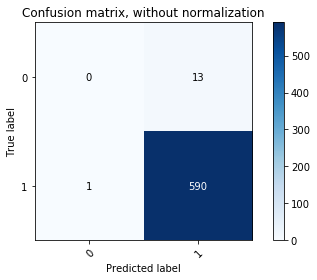

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.98      1.00      0.99       591

    accuracy                           0.98       604
   macro avg       0.49      0.50      0.49       604
weighted avg       0.96      0.98      0.97       604

...upperbound (95%)


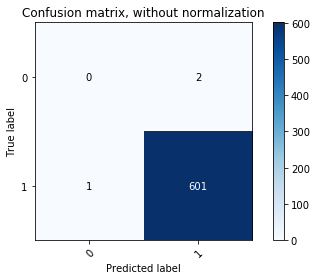

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00       602

    accuracy                           1.00       604
   macro avg       0.50      0.50      0.50       604
weighted avg       0.99      1.00      0.99       604



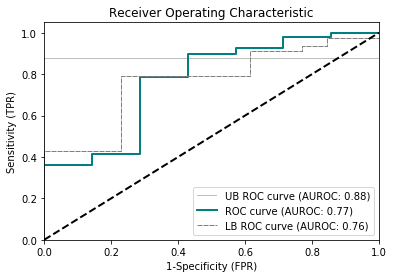

Specific
--------------------------------------------------------------------------------
Specific - train
--------------------------------------------------------------------------------
Accuracy: 0.882


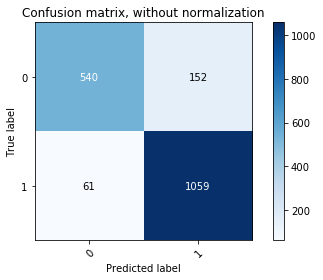

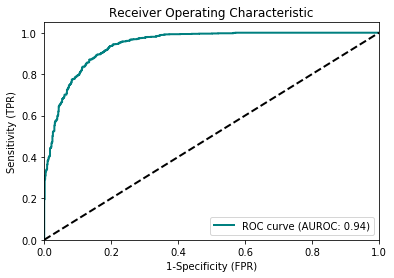

              precision    recall  f1-score   support

           0       0.90      0.78      0.84       692
           1       0.87      0.95      0.91      1120

    accuracy                           0.88      1812
   macro avg       0.89      0.86      0.87      1812
weighted avg       0.88      0.88      0.88      1812

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


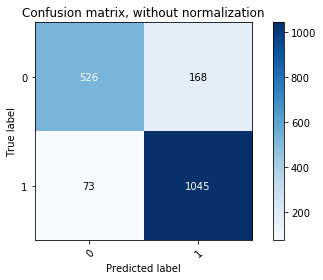

              precision    recall  f1-score   support

           0       0.88      0.76      0.81       694
           1       0.86      0.93      0.90      1118

    accuracy                           0.87      1812
   macro avg       0.87      0.85      0.86      1812
weighted avg       0.87      0.87      0.86      1812

...upperbound (95%)


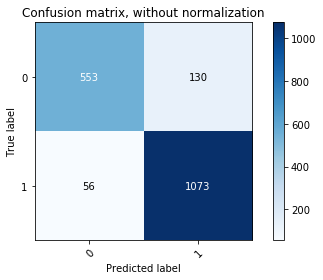

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       683
           1       0.89      0.95      0.92      1129

    accuracy                           0.90      1812
   macro avg       0.90      0.88      0.89      1812
weighted avg       0.90      0.90      0.90      1812



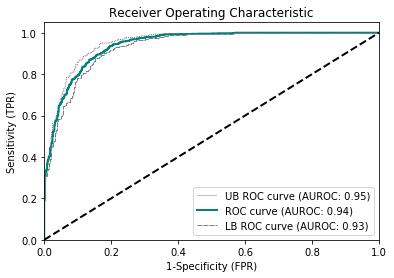

--------------------------------------------------------------------------------
Specific - test
--------------------------------------------------------------------------------
Accuracy: 0.707


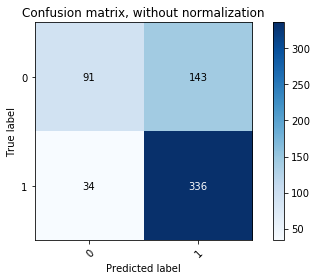

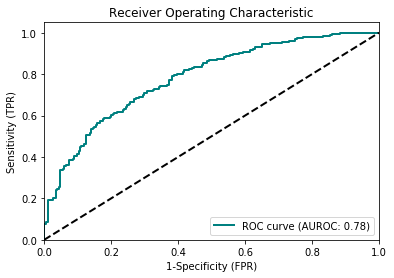

              precision    recall  f1-score   support

           0       0.73      0.39      0.51       234
           1       0.70      0.91      0.79       370

    accuracy                           0.71       604
   macro avg       0.71      0.65      0.65       604
weighted avg       0.71      0.71      0.68       604

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


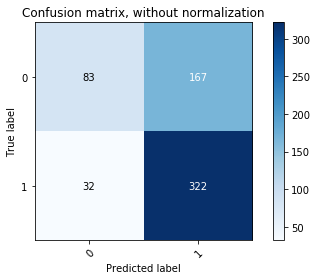

              precision    recall  f1-score   support

           0       0.72      0.33      0.45       250
           1       0.66      0.91      0.76       354

    accuracy                           0.67       604
   macro avg       0.69      0.62      0.61       604
weighted avg       0.68      0.67      0.64       604

...upperbound (95%)


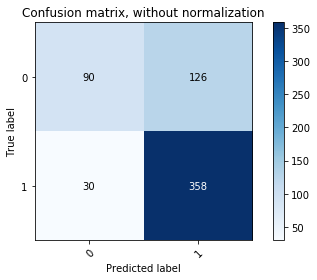

              precision    recall  f1-score   support

           0       0.75      0.42      0.54       216
           1       0.74      0.92      0.82       388

    accuracy                           0.74       604
   macro avg       0.74      0.67      0.68       604
weighted avg       0.74      0.74      0.72       604



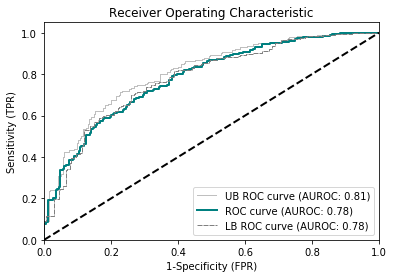

Corrective
--------------------------------------------------------------------------------
Corrective - train
--------------------------------------------------------------------------------
Accuracy: 0.887


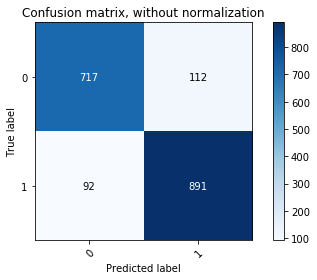

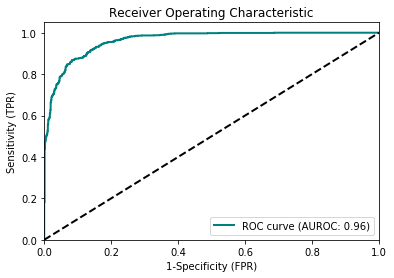

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       829
           1       0.89      0.91      0.90       983

    accuracy                           0.89      1812
   macro avg       0.89      0.89      0.89      1812
weighted avg       0.89      0.89      0.89      1812

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


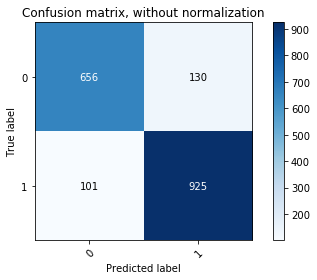

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       786
           1       0.88      0.90      0.89      1026

    accuracy                           0.87      1812
   macro avg       0.87      0.87      0.87      1812
weighted avg       0.87      0.87      0.87      1812

...upperbound (95%)


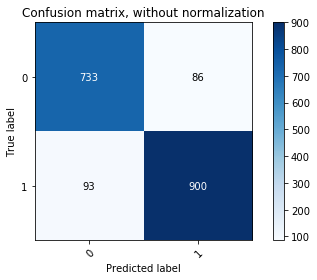

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       819
           1       0.91      0.91      0.91       993

    accuracy                           0.90      1812
   macro avg       0.90      0.90      0.90      1812
weighted avg       0.90      0.90      0.90      1812



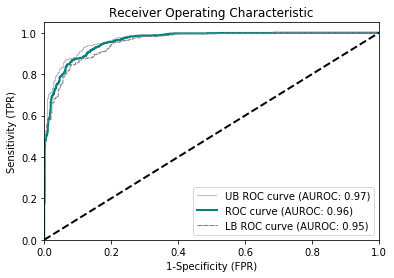

--------------------------------------------------------------------------------
Corrective - test
--------------------------------------------------------------------------------
Accuracy: 0.805


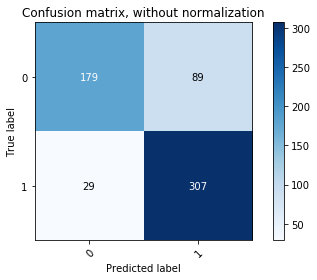

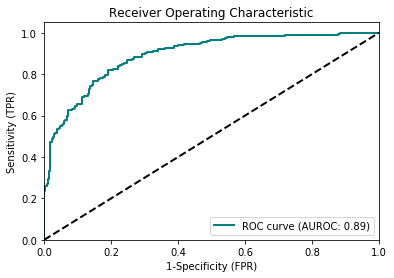

              precision    recall  f1-score   support

           0       0.86      0.67      0.75       268
           1       0.78      0.91      0.84       336

    accuracy                           0.80       604
   macro avg       0.82      0.79      0.80       604
weighted avg       0.81      0.80      0.80       604

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


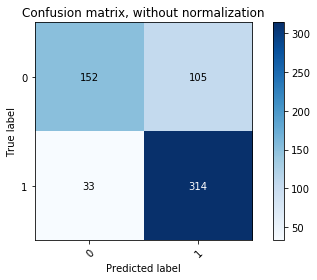

              precision    recall  f1-score   support

           0       0.82      0.59      0.69       257
           1       0.75      0.90      0.82       347

    accuracy                           0.77       604
   macro avg       0.79      0.75      0.75       604
weighted avg       0.78      0.77      0.76       604

...upperbound (95%)


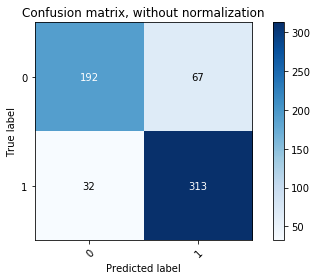

              precision    recall  f1-score   support

           0       0.86      0.74      0.80       259
           1       0.82      0.91      0.86       345

    accuracy                           0.84       604
   macro avg       0.84      0.82      0.83       604
weighted avg       0.84      0.84      0.83       604



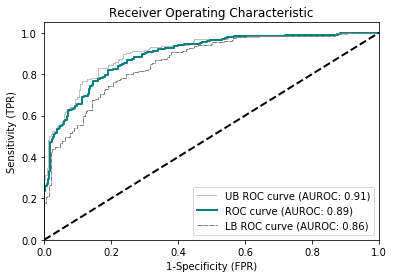

Final
--------------------------------------------------------------------------------
Final - train
--------------------------------------------------------------------------------
Accuracy: 0.896


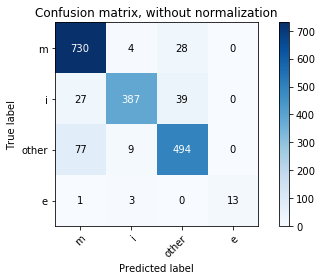

              precision    recall  f1-score   support

           e       0.87      0.96      0.91       762
           i       0.96      0.85      0.90       453
           m       0.88      0.85      0.87       580
       other       1.00      0.76      0.87        17

    accuracy                           0.90      1812
   macro avg       0.93      0.86      0.89      1812
weighted avg       0.90      0.90      0.90      1812

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


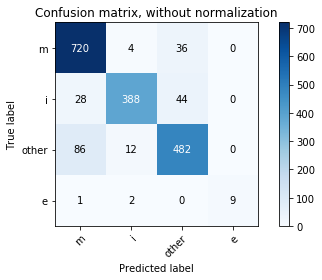

              precision    recall  f1-score   support

           e       0.86      0.95      0.90       760
           i       0.96      0.84      0.90       460
           m       0.86      0.83      0.84       580
       other       1.00      0.75      0.86        12

    accuracy                           0.88      1812
   macro avg       0.92      0.84      0.88      1812
weighted avg       0.89      0.88      0.88      1812

...upperbound (95%)


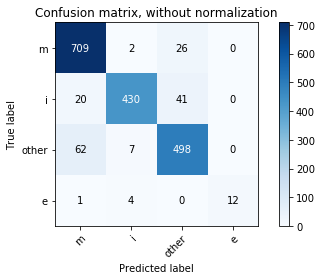

              precision    recall  f1-score   support

           e       0.90      0.96      0.93       737
           i       0.97      0.88      0.92       491
           m       0.88      0.88      0.88       567
       other       1.00      0.71      0.83        17

    accuracy                           0.91      1812
   macro avg       0.94      0.86      0.89      1812
weighted avg       0.91      0.91      0.91      1812

--------------------------------------------------------------------------------
Final - test
--------------------------------------------------------------------------------
Accuracy: 0.649


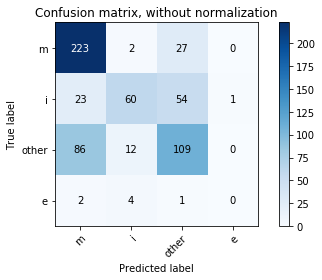

              precision    recall  f1-score   support

           e       0.67      0.88      0.76       252
           i       0.77      0.43      0.56       138
           m       0.57      0.53      0.55       207
       other       0.00      0.00      0.00         7

    accuracy                           0.65       604
   macro avg       0.50      0.46      0.47       604
weighted avg       0.65      0.65      0.63       604

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


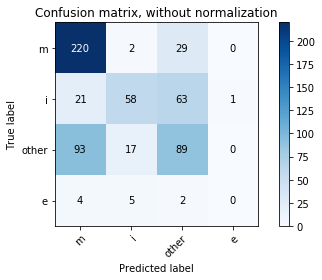

              precision    recall  f1-score   support

           e       0.65      0.88      0.75       251
           i       0.71      0.41      0.52       143
           m       0.49      0.45      0.47       199
       other       0.00      0.00      0.00        11

    accuracy                           0.61       604
   macro avg       0.46      0.43      0.43       604
weighted avg       0.60      0.61      0.59       604

...upperbound (95%)


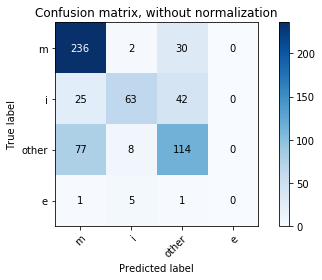

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           e       0.70      0.88      0.78       268
           i       0.81      0.48      0.61       130
           m       0.61      0.57      0.59       199
       other       0.00      0.00      0.00         7

    accuracy                           0.68       604
   macro avg       0.53      0.48      0.49       604
weighted avg       0.68      0.68      0.67       604

Final_High
--------------------------------------------------------------------------------
Final_High - train
--------------------------------------------------------------------------------
Accuracy: 0.914


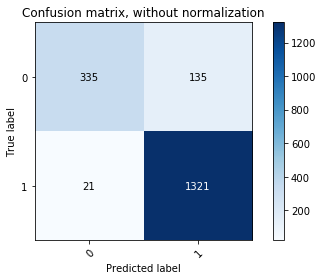

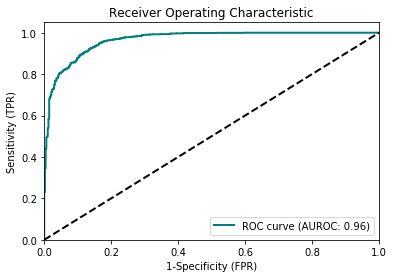

              precision    recall  f1-score   support

           0       0.94      0.71      0.81       470
           1       0.91      0.98      0.94      1342

    accuracy                           0.91      1812
   macro avg       0.92      0.85      0.88      1812
weighted avg       0.92      0.91      0.91      1812

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


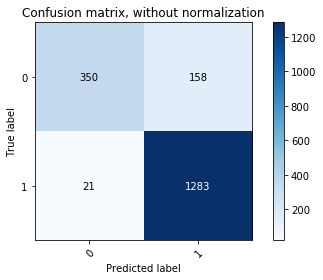

              precision    recall  f1-score   support

           0       0.94      0.69      0.80       508
           1       0.89      0.98      0.93      1304

    accuracy                           0.90      1812
   macro avg       0.92      0.84      0.87      1812
weighted avg       0.91      0.90      0.90      1812

...upperbound (95%)


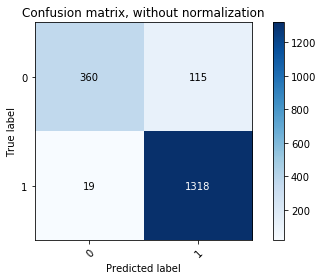

              precision    recall  f1-score   support

           0       0.95      0.76      0.84       475
           1       0.92      0.99      0.95      1337

    accuracy                           0.93      1812
   macro avg       0.93      0.87      0.90      1812
weighted avg       0.93      0.93      0.92      1812



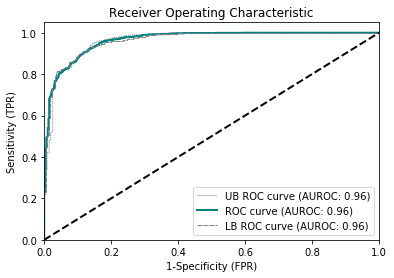

--------------------------------------------------------------------------------
Final_High - test
--------------------------------------------------------------------------------
Accuracy: 0.826


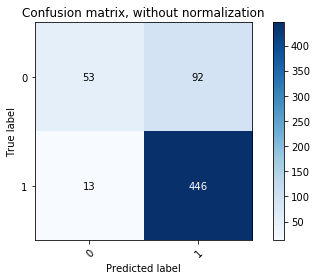

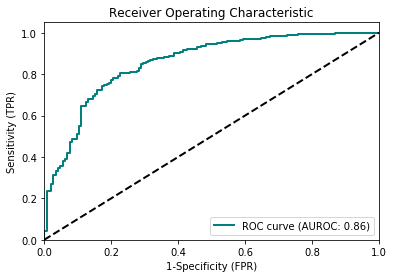

              precision    recall  f1-score   support

           0       0.80      0.37      0.50       145
           1       0.83      0.97      0.89       459

    accuracy                           0.83       604
   macro avg       0.82      0.67      0.70       604
weighted avg       0.82      0.83      0.80       604

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


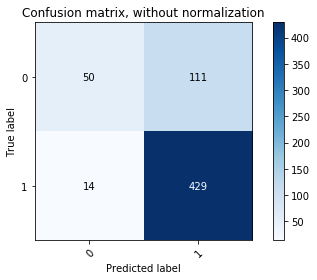

              precision    recall  f1-score   support

           0       0.78      0.31      0.44       161
           1       0.79      0.97      0.87       443

    accuracy                           0.79       604
   macro avg       0.79      0.64      0.66       604
weighted avg       0.79      0.79      0.76       604

...upperbound (95%)


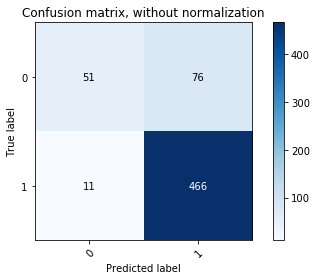

              precision    recall  f1-score   support

           0       0.82      0.40      0.54       127
           1       0.86      0.98      0.91       477

    accuracy                           0.86       604
   macro avg       0.84      0.69      0.73       604
weighted avg       0.85      0.86      0.84       604



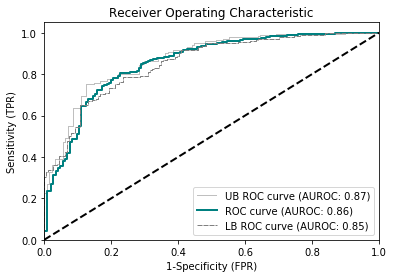

In [24]:
for i, label in enumerate(label_names):
    print(label)
    
    train_label = list(Y_train[:, i])
    best.fit(X_train, train_label)
    
    train_pred = best.predict(X_train)
    print("--------------------------------------------------------------------------------")
    print("%s - train" %(label))
    print("--------------------------------------------------------------------------------")
    evaluate(best, X_train, train_label)
    
    
    test_label = list(Y_test[:, i])
    test_pred = best.predict(X_test)
    print("--------------------------------------------------------------------------------")
    print("%s - test" %(label))
    print("--------------------------------------------------------------------------------")
    evaluate(best, X_test, test_label)
    
    print("================================================================================")

In [76]:
dump(best, 'bestmodel.joblib') 

['bestmodel.joblib']

In [17]:
best = load('bestmodel.joblib') 

In [18]:
best.get_params()

{'memory': None,
 'steps': [('countvectorizer',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 5), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('tfidftransformer',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=False)),
  ('logisticregression',
   LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=0.15, max_iter=200,
                      multi_class='auto', n_jobs=None, penalty='elasticnet',
                      random_state=0, solver='saga', tol=0.01, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'countvectorizer': C

# Compare to Old Model - Trained on Sam's Data

In [95]:
old = make_pipeline(CountVectorizer(), 
              TfidfTransformer(), 
              SGDClassifier(loss='log', penalty='l2', alpha=1e-3, max_iter=5, tol=-np.infty))

In [96]:
sams_data = pd.read_csv("/home/jovyan/Documents/workspace/SIMPL_NLP/Data/Final_Concordant/Formatted_Data.csv")

In [97]:
sams_data
sams_data = sams_data.apply(lambda x: x.astype(str).str.lower())
sams_data['Final_High'] = sams_data['Final Code'].isin(['e', 'm'])
sams_data['Final_High'] = sams_data['Final_High'].replace({True: 1, False: 0})

## have to make tokens match between both datasets

In [98]:
"""
List from sam's data cleaning
(' *resident_n* ', ['[resident name]']),
(' *rotation_n* ', ['[ rotation name removed]', '[removed rotation name]', '[rotation name]', '[rotation name}']),
(' *patient_n* ', ['[patient name]', "[patient's name]"]),
(' *patient_age*', ['[patient age]', ]),
(' *hospital_n* ', ['[hospital name]', ]),
(' *location_n*', ['[location removed]', ]),
(' *n* ', ['[name removed}', '[name]', '[name', 'o9name removed)']),
(' *u* ', ['[unkown]', '[unknown]', '[unnknown]', '[unkonwn]', '[unnkown]']),
(' *r* ', ['[removed]', '{removed]'])
"""

'\nList from sam\'s data cleaning\n(\' *resident_n* \', [\'[resident name]\']),\n(\' *rotation_n* \', [\'[ rotation name removed]\', \'[removed rotation name]\', \'[rotation name]\', \'[rotation name}\']),\n(\' *patient_n* \', [\'[patient name]\', "[patient\'s name]"]),\n(\' *patient_age*\', [\'[patient age]\', ]),\n(\' *hospital_n* \', [\'[hospital name]\', ]),\n(\' *location_n*\', [\'[location removed]\', ]),\n(\' *n* \', [\'[name removed}\', \'[name]\', \'[name\', \'o9name removed)\']),\n(\' *u* \', [\'[unkown]\', \'[unknown]\', \'[unnknown]\', \'[unkonwn]\', \'[unnkown]\']),\n(\' *r* \', [\'[removed]\', \'{removed]\'])\n'

In [99]:
import re

token_list = []
for i in X_train:
    token_list += re.findall("\[.*?\]", i)
set(token_list)

{'[attend_name]',
 '[ch]',
 '[location]',
 '[name]',
 '[patient_name]',
 '[res_name]'}

In [100]:
pat_repl = [("*resident_n*", "[res_name]"),
            ("*patient_n*", "[patient_name]"),
            ("*location_n*", "[location]")]

for pat, repl in pat_repl:
    sams_data["Text"] = sams_data["Text"].str.replace(pat, repl, regex=False)
    
sams_data.head()

,Eval ID,Text,Final Code,Final_High
0,1,"[res_name] handles tissue with care, is able...",e,1
1,2,has come a long way this year and has greatly...,m,1
2,3,obviously this was a very difficult procedure...,e,1
3,4,*n* did a fantastic job. he is full of energ...,other,0
4,5,*n* was coordinated and skilled. she perform...,m,1


In [101]:
X_sam = list(sams_data["Text"])
Y_sam = sams_data["Final_High"].to_numpy()

In [102]:
old.fit(X_sam,Y_sam)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, voc...
                ('sgdclassifier',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='log', max_iter=5,
  

In [103]:
# Compare models

In [104]:
np.mean(Y_sam == old.predict(X_sam))

0.94

In [105]:
np.mean(Y_sam == best.predict(X_sam))

0.7283333333333334

Best (new) Model
Accuracy: 0.826


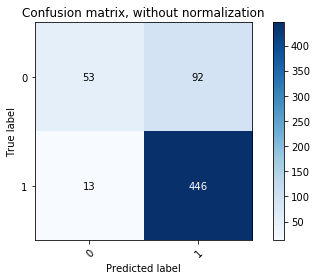

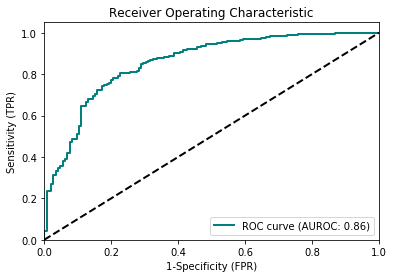

              precision    recall  f1-score   support

           0       0.80      0.37      0.50       145
           1       0.83      0.97      0.89       459

    accuracy                           0.83       604
   macro avg       0.82      0.67      0.70       604
weighted avg       0.82      0.83      0.80       604

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


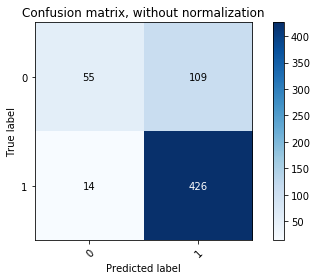

              precision    recall  f1-score   support

           0       0.80      0.34      0.47       164
           1       0.80      0.97      0.87       440

    accuracy                           0.80       604
   macro avg       0.80      0.65      0.67       604
weighted avg       0.80      0.80      0.76       604

...upperbound (95%)


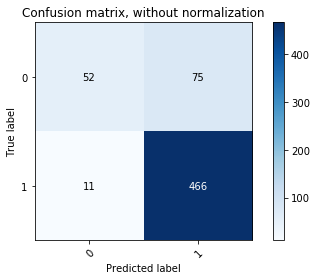

              precision    recall  f1-score   support

           0       0.83      0.41      0.55       127
           1       0.86      0.98      0.92       477

    accuracy                           0.86       604
   macro avg       0.84      0.69      0.73       604
weighted avg       0.85      0.86      0.84       604



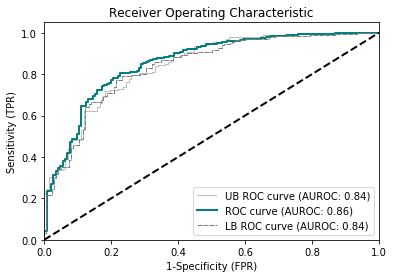

Sam's Data (old/pilot) Model
Accuracy: 0.768


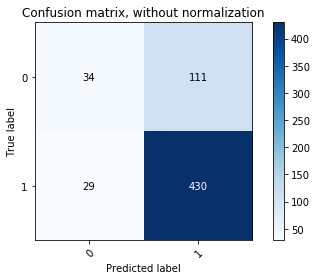

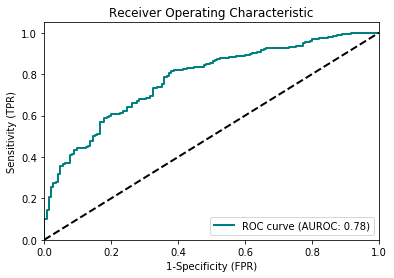

              precision    recall  f1-score   support

           0       0.54      0.23      0.33       145
           1       0.79      0.94      0.86       459

    accuracy                           0.77       604
   macro avg       0.67      0.59      0.59       604
weighted avg       0.73      0.77      0.73       604

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


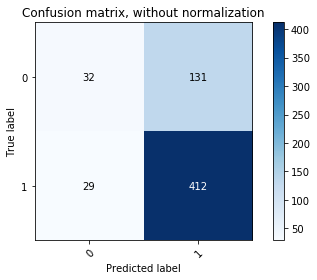

              precision    recall  f1-score   support

           0       0.52      0.20      0.29       163
           1       0.76      0.93      0.84       441

    accuracy                           0.74       604
   macro avg       0.64      0.57      0.56       604
weighted avg       0.70      0.74      0.69       604

...upperbound (95%)


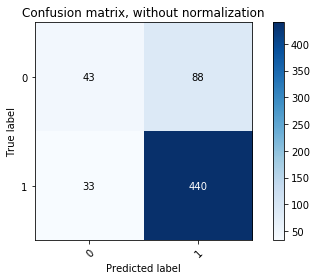

              precision    recall  f1-score   support

           0       0.57      0.33      0.42       131
           1       0.83      0.93      0.88       473

    accuracy                           0.80       604
   macro avg       0.70      0.63      0.65       604
weighted avg       0.78      0.80      0.78       604



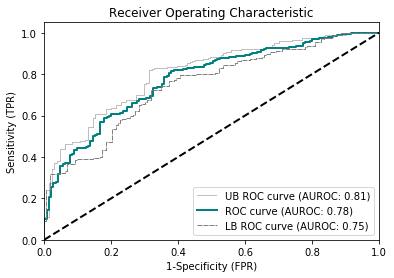

In [134]:
print("================================================================================")
print("Best (new) Model")
print("================================================================================")
primary_test_label = list(Y_test[:, pl_idx])
evaluate(best, X_test, primary_test_label)
print("================================================================================")
print("Sam's Data (old/pilot) Model")
print("================================================================================")
primary_test_label = list(Y_test[:, pl_idx])
evaluate(old, X_test, primary_test_label)

Accuracy: 0.826


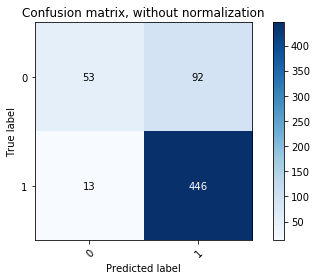

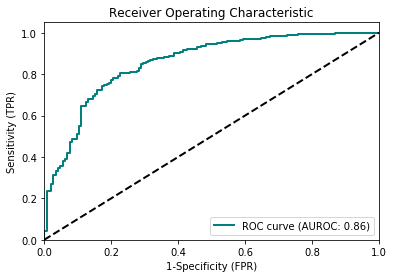

              precision    recall  f1-score   support

           0       0.80      0.37      0.50       145
           1       0.83      0.97      0.89       459

    accuracy                           0.83       604
   macro avg       0.82      0.67      0.70       604
weighted avg       0.82      0.83      0.80       604

--------------------------------------------------------------------------------
bootstrapping on accuracy...
...lowerbound (5%)


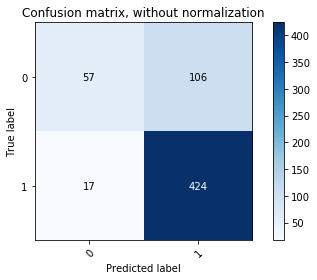

              precision    recall  f1-score   support

           0       0.77      0.35      0.48       163
           1       0.80      0.96      0.87       441

    accuracy                           0.80       604
   macro avg       0.79      0.66      0.68       604
weighted avg       0.79      0.80      0.77       604

...upperbound (95%)


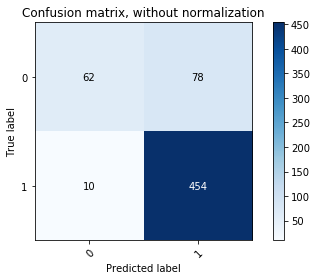

              precision    recall  f1-score   support

           0       0.86      0.44      0.58       140
           1       0.85      0.98      0.91       464

    accuracy                           0.85       604
   macro avg       0.86      0.71      0.75       604
weighted avg       0.86      0.85      0.84       604



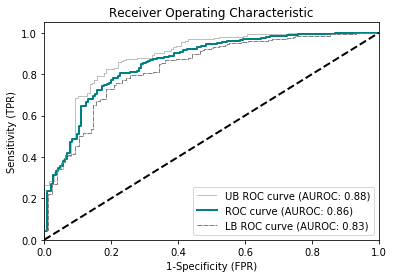

In [126]:
evaluate(best, X_test, primary_test_label)

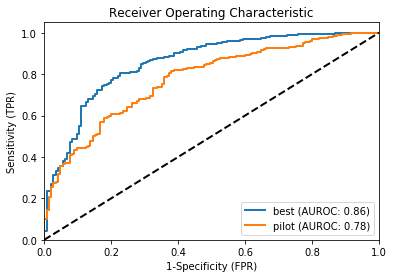

In [133]:
compare_roc_curve(
    (primary_test_label, best.predict_proba(X_test)[:,1], "best"),
    (primary_test_label, old.predict_proba(X_test)[:,1], "pilot")
)

In [122]:
def compare_roc_curve(*y_p_n_tuple_argv):
    
    plt.figure()
    lw = 2
    
    for y, p, n in y_p_n_tuple_argv:
        fpr, tpr, thresholds = metrics.roc_curve(y, p)
        roc_auc = metrics.auc(fpr, tpr)  

        plt.plot(fpr, tpr, lw=lw, label='%s (AUROC: %0.2f)' %(n, roc_auc))
        
    
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()